<a href="https://colab.research.google.com/github/tseykoroman/ML_for_business/blob/main/Tseyko_Lesson_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 5. Задача оттока: варианты постановки, возможные способы решения##

Давайте поработаем с набором данных с платформы kaggle https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers по оттоку клиентов банка

In [177]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from datetime import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

import itertools

import matplotlib.pyplot as plt

%matplotlib inline



import random

random.seed(666)
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

Ссылка на google drive: https://drive.google.com/file/d/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91

In [178]:
# !wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O churn_data.csv

In [179]:
df = pd.read_csv("C:/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [180]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [181]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [182]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [183]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [184]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

Посмотрим как это работает на примере отдельного категориального признака - Gender

In [185]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])

gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


Аналогичный пример для вещественного признака (здесь мы не применяем какое-либо преобразование, а просто столбец как есть)

In [186]:
numr = Pipeline([
                ('selector', NumberSelector(key='CreditScore')),            
            ])

numr.fit(X_train)
numr.transform(X_test).head(3)

,CreditScore
9394,597
898,523
2398,706


1. **Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:**
    - бустинг
    - логистическая регрессия

Теперь нам нужно под каждый признак создать трансформер и объединить их в список.

In [187]:
from sklearn.preprocessing import StandardScaler

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [188]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модели

In [189]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [190]:
def training(classifier, classifier_name):
    from sklearn.metrics import roc_auc_score

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    y_score = classifier.predict_proba(X_test)[:, 1]
    
    # расчтаем метрики
    b = 1
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc_score = roc_auc_score(y_test, y_score)
    ix = np.argmax(fscore)
    cm = confusion_matrix(y_test, y_score>thresholds[ix])

    # мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}
    plt.rc('font', **font)
    plt.figure(figsize=(6, 4))
    plot_confusion_matrix(cm, classes=['NonChurn', 'Churn'], title=f'Confusion matrix for {classifier_name}')
    # plt.savefig("conf_matrix.png")
    plt.show()
 
    return [round(i, 3) for i in [thresholds[ix], fscore[ix], precision[ix], recall[ix], roc_auc_score, cm[1,1], cm[0,1], cm[0,0], cm[1,0]]]

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


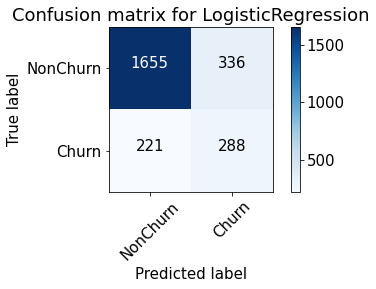

Confusion matrix, without normalization
[[1833  158]
 [ 195  314]]


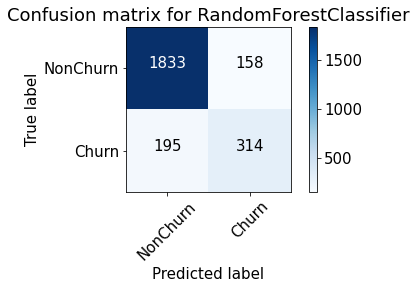

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


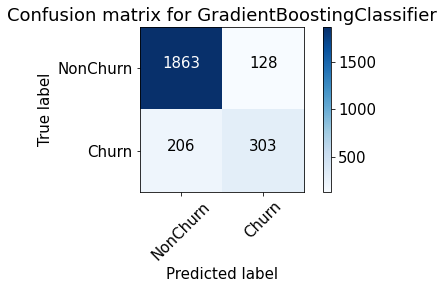

Confusion matrix, without normalization
[[1793  198]
 [ 188  321]]


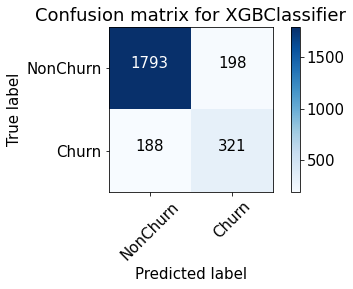

In [192]:
results = pd.DataFrame([
    training(classifier=Pipeline([('features', feats), ('classifier', LogisticRegression(random_state=42))]), classifier_name='LogisticRegression'),
    training(classifier=Pipeline([('features', feats), ('classifier', RandomForestClassifier(random_state=42))]), classifier_name='RandomForestClassifier'),
    training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42))]), classifier_name='GradientBoostingClassifier'),
    training(classifier=Pipeline([('features', feats), ('classifier', xgb.XGBClassifier(random_state=42, 
                                                                                        use_label_encoder=False, 
                                                                                        eval_metric='logloss'))]), classifier_name='XGBClassifier') 
], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC', 'TP', 'FP', 'TN', 'FN'])

results['models'] = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier']
results = results.set_index('models')

In [193]:
results

,Best Threshold,F,Precision,Recall,ROC AUC,TP,FP,TN,FN
models,,,,,,,,,
LogisticRegression,0.290,0.510,0.462,0.568,0.772,288,336,1655,221
RandomForestClassifier,0.380,0.641,0.654,0.629,0.864,314,158,1833,195
GradientBoostingClassifier,0.409,0.646,0.704,0.597,0.876,303,128,1863,206
XGBClassifier,0.373,0.626,0.619,0.633,0.861,321,198,1793,188


2. **Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)**

Наиболее подходщая метрика это Precision. Т.о. лучшая модель - GradientBoostingClassifier.

3.**Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:**
    - 1 доллар на удержание
    - 2 доллара - с каждого правильно классифицированного (True Positive)

In [194]:
retain_sum = (results['FP']['GradientBoostingClassifier'] + results['TP']['GradientBoostingClassifier']) * 1
income = results['TP']['GradientBoostingClassifier'] * 2

income - retain_sum

175

4. **Провести подбор гиперпараметров лучшей модели по итогам 2-3**

Сетка с параметрами

In [195]:
from sklearn.model_selection import GridSearchCV

params = {
    #'classifier__loss':["deviance"],
    'classifier__learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    #'classifier__min_samples_split': np.linspace(0.1, 0.5, 12),
    #'classifier__min_samples_leaf': np.linspace(0.1, 0.5, 12),
    'classifier__max_depth':[3,5,8],
    'classifier__max_features':["log2","sqrt"],
    #'classifier__criterion': ["friedman_mse",  "mae"],
    #'classifier__subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    'classifier__n_estimators':[10, 50, 100]
}

In [196]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', GradientBoostingClassifier()),
])

Запускаем перебор

In [197]:
%%time
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

Wall time: 4min 23s


{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 100}

In [198]:
search.best_params_

{'classifier__learning_rate': 0.05,
 'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 100}

Обучаем модель уже с новыми параметрами

Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


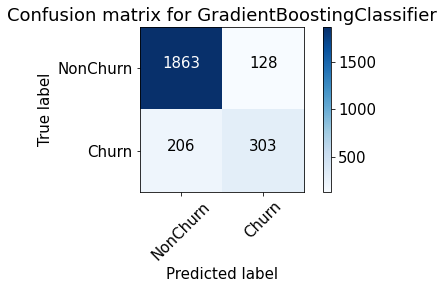

Confusion matrix, without normalization
[[1774  217]
 [ 167  342]]


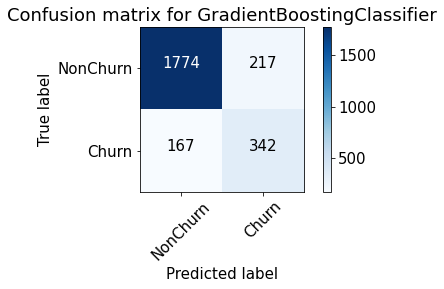

In [202]:
results = pd.DataFrame([
 training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42))]), classifier_name='GradientBoostingClassifier'),
 training(classifier=Pipeline([('features', feats), ('classifier', GradientBoostingClassifier(random_state=42, 
                                                                                        learning_rate=0.05,
                                                                                        max_depth=5,
                                                                                        max_features='sqrt',
                                                                                        n_estimators=100))]), classifier_name='GradientBoostingClassifier')
    ], columns=['Best Threshold', 'F', 'Precision', 'Recall', 'ROC AUC', 'TP', 'FP', 'TN', 'FN'])

results['models'] = ['GradientBoostingClassifier', 'GradientBoostingClassifier_2']
results = results.set_index('models')

5. **Еще раз провести оценку экономической эффективности**

In [203]:
retain_sum = (results['FP']['GradientBoostingClassifier'] + results['TP']['GradientBoostingClassifier']) * 1
income = results['TP']['GradientBoostingClassifier'] * 2

income - retain_sum

175

In [205]:
retain_sum = (results['FP']['GradientBoostingClassifier'] + results['TP']['GradientBoostingClassifier']) * 1
income = results['TP']['GradientBoostingClassifier'] * 2

income - retain_sum

175

In [206]:
results

,Best Threshold,F,Precision,Recall,ROC AUC,TP,FP,TN,FN
models,,,,,,,,,
GradientBoostingClassifier,0.409,0.646,0.704,0.597,0.876,303,128,1863,206
GradientBoostingClassifier_2,0.300,0.642,0.612,0.674,0.872,342,217,1774,167


Как мы видим экономическая эффективность не изменилась, f-score уменьшился, нужно подбирать другие параметры для 

## Домашнее задание

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями:
    - бустинг
    - логистическая регрессия
2. Отобрать лучшую модель по метрикам (какая по вашему мнению здесь наиболее подходящая ML-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2:
    - 1 доллар на удержание
    - 2 доллара - с каждого правильно классифицированного (True Positive)
4. *Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. *Еще раз провести оценку экономической эффективности

## Ссылки

1. http://hyperopt.github.io/hyperopt/
2. https://arxiv.org/pdf/1907.03947.pdf
3. https://arxiv.org/pdf/1802.02301.pdf
4. https://arxiv.org/list/stat.ML/recent
5. https://scikit-learn.org/stable/modules/grid_search.html
6. https://scikit-learn.org/stable/modules/compose.html